In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import math                             # Added the math lib for math.isnan()

titanic = pd.read_csv('./Titanic.csv')

# Display the first few rows of the dataframe
titanic.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Step 1

In [2]:
def QuantileBinning(feature, bin_number):
    """
    This function takes a numerical feature and the number of bins, and
    returns the feature binned into quantile-based bins.

    Parameters:
    - feature (pandas.Series): The numerical feature to be binned.
    - bin_number (int): The number of quantile bins.

    Returns:
    - pandas.Series: A series of discrete features binned by quantile.
    """
    # Use qcut to create quantile-based bins for the feature
    # If there are fewer unique values than bins, qcut could throw an error.
    # 'duplicates' parameter handles this by dropping redundant bins.
    return pd.qcut(feature, q=bin_number, labels=False, duplicates='drop')

# One example
feature_test = pd.DataFrame(np.random.rand(100),  columns=['Column_A'])
feature_test_discrete = QuantileBinning(feature_test['Column_A'], 10)

def label_encoder(feature):
    unique_labels = pd.unique(feature)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    transformed_feature = np.array([label_to_int[label] for label in feature])
    return transformed_feature

In [3]:
# Fill missing values in 'age' with the average age
from sklearn.model_selection import train_test_split

mean_age = 0    # sum of ages
i = 0           # Number of valid ages
for age in titanic["age"]:
    age = float(age)
    if not(math.isnan(age)):
        mean_age += age
        i += 1
mean_age = mean_age/i

for index, row in titanic.iterrows():
    # Replace NaNs
    if math.isnan(row["age"]):
        titanic.loc[index, "age"] = mean_age

    # Check if equal to 1 or 0
                                                   
# Discretization
INDEPENDENT_VARIABLES = ["pclass",
                         "sex",
                         "age",
                         "sibsp"]
DEPENDENT_VARIABLE = "survived"
x_data = titanic.loc[:, INDEPENDENT_VARIABLES]
y_data = titanic.loc[:, DEPENDENT_VARIABLE]


# Split the data into 80% training and 20% test sets
x_training, x_testing, y_training, y_testing = train_test_split(
    x_data,
    y_data,
    test_size = 0.2
)

# Step 2

In [4]:
### Implementing quantile binning ###
NUM_BINS = 10
x_training["age"] = QuantileBinning(x_training["age"], NUM_BINS)
x_testing["age"] = QuantileBinning(x_testing["age"], NUM_BINS)

# define your entropy function and information gain function
def calc_entropy(x_data, y_data):
    total_samples = len(x_data)
    value_vec = x_data.unique()
    temp_df = pd.concat([x_data, y_data], 
                        axis=1,
                        keys=["x_data","y_data"])
    entropy_vec = []
    for novel_value in value_vec:
        p = 0
        n = 0
        t = 0
        for index, row in temp_df.iterrows():
            if row["x_data"] == novel_value:
                if row["y_data"] == 1:
                    p += 1
                else:
                    n += 1
                t += 1
        entropy_vec.append(
            (t/total_samples) * ((-p/t)*np.log2(p/t) - (n/t)*np.log2(n/t))
        )
    
    return sum(entropy_vec)

p = y_training.value_counts()[1]
n = y_training.value_counts()[0]
t = len(y_training)
baseline = (-p/t)*np.log2(p/t) - (n/t)*np.log2(n/t)
info_gains = {}
for attribute in INDEPENDENT_VARIABLES:
    this_entropy = calc_entropy(x_training[attribute], y_training)
    info_gains[attribute] = baseline - this_entropy

print(info_gains)


/var/folders/p4/xs6f6dtd5c36n61ghmv853580000gn/T/ipykernel_1636/2195671806.py:26: RuntimeWarning: divide by zero encountered in log2
  (t/total_samples) * ((-p/t)*np.log2(p/t) - (n/t)*np.log2(n/t))
/var/folders/p4/xs6f6dtd5c36n61ghmv853580000gn/T/ipykernel_1636/2195671806.py:26: RuntimeWarning: invalid value encountered in scalar multiply
  (t/total_samples) * ((-p/t)*np.log2(p/t) - (n/t)*np.log2(n/t))


{'pclass': 0.0661723031196707, 'sex': 0.20730216229936294, 'age': 0.01736044435065265, 'sibsp': nan}


So the first split should be "sex"

# Step 3

[Text(0.4816666666666667, 0.9285714285714286, 'x[0] <= 0.5\ngini = 0.469\nsamples = 1047\nvalue = [653, 394]'),
 Text(0.19, 0.7857142857142857, 'x[1] <= 0.5\ngini = 0.302\nsamples = 675\nvalue = [550, 125]'),
 Text(0.06333333333333334, 0.6428571428571429, 'x[3] <= 0.5\ngini = 0.448\nsamples = 142\nvalue = [94, 48]'),
 Text(0.02666666666666667, 0.5, 'x[2] <= 0.5\ngini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.013333333333333334, 0.35714285714285715, 'gini = 0.375\nsamples = 4\nvalue = [1, 3]'),
 Text(0.04, 0.35714285714285715, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.1, 0.5, 'x[3] <= 7.5\ngini = 0.432\nsamples = 136\nvalue = [93, 43]'),
 Text(0.06666666666666667, 0.35714285714285715, 'x[2] <= 0.5\ngini = 0.457\nsamples = 102\nvalue = [66, 36]'),
 Text(0.04, 0.21428571428571427, 'x[3] <= 6.5\ngini = 0.432\nsamples = 76\nvalue = [52, 24]'),
 Text(0.02666666666666667, 0.07142857142857142, 'gini = 0.456\nsamples = 57\nvalue = [37, 20]'),
 Text(0.05333333333333334, 0.0714285

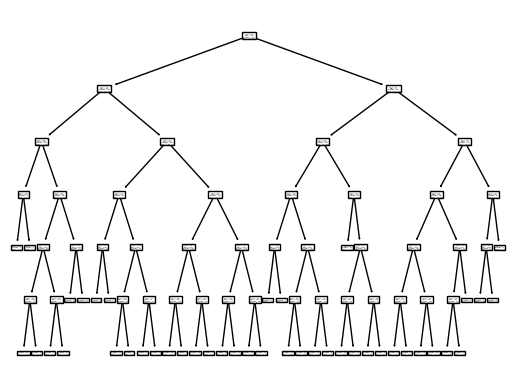

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree #sklearn.metrics is not imported !!!

# Instantiate the DecisionTreeClassifier
tree_classifier = DecisionTreeClassifier(max_depth=6)

# Prepare the features and target variables for training
# Values in "sex" and "pclass" need to be replaced w floats
                   
feature_list = pd.concat([x_training["sex"].replace({"male": 0,
                                                    "female": 1}),
                          x_training["pclass"].replace({"1st":0,
                          "2nd":1,
                          "3rd":2}),
                          x_training["sibsp"],
                          x_training["age"]],
                          axis=1
)

# Fit the decision tree model
tree_classifier.fit(feature_list.values,
                    y_training)

# Plot the full decision tree
plot_tree(tree_classifier)


In [30]:
# Define your performance metrics including accuracy, precision, recall and F1-score

def test_tree(x_testing, y_testing, model):
    # Pass in test datasets for x and y as well as the trained model
    # Return precision, recall, F1 score
    # Some definitions upfront
    positive = 1    # Value of a Positive
    negative = 0    # Value of a Negative
    TP = 0          # Num. of true positives
    TN = 0          # Num. of true negatives
    FP = 0          # Num. of false positives
    FN = 0          # Num. of false negatives

    for index, row in x_testing.iterrows():
        prediction = model.predict([row.values])
        if prediction == y_testing[index] == positive:
            TP += 1
        elif prediction == y_testing[index] == negative:
            TN += 1
        else:
            if y_testing[index] == positive:
                FN += 1
            elif y_testing[index] == negative:
                FP += 1

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*(precision * recall)/(precision + recall)
    return precision, recall, F1

feature_list_testing = pd.concat([x_testing["sex"].replace({"male": 0,
                                                    "female": 1}),
                          x_testing["pclass"].replace({"1st":0,
                          "2nd":1,
                          "3rd":2}),
                          x_testing["sibsp"],
                          x_testing["age"]],
                          axis=1
                        )

print(test_tree(feature_list_testing, y_testing, tree_classifier))


(0.7906976744186046, 0.6415094339622641, 0.7083333333333334)


# Step 4

(0.8, 0.6415094339622641, 0.7120418848167539)


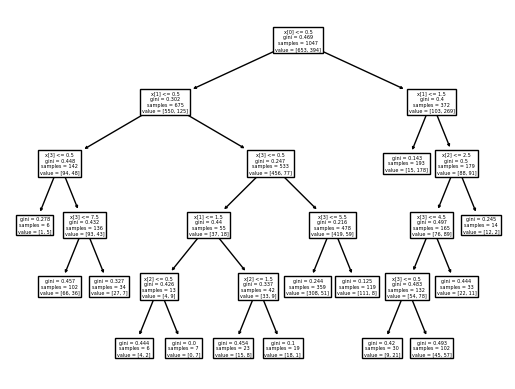

In [43]:
from sklearn.model_selection import GridSearchCV

# Define a range of max_leaf_nodes values to search
param_grid = {'max_leaf_nodes': list(range(5, 20))}

# Run grid search with cross-validation
def train_model(x_training, y_training, param_grid):
    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
    grid_search.fit(x_training.values, y_training) # Note testing set cannot be used
    return grid_search.best_estimator_

# Get the best estimator with the optimal max_leaf_nodes parameter
best_tree = train_model(feature_list, y_training, param_grid)

# Plot the pruned decision tree
plot_tree(best_tree)
print(test_tree(feature_list_testing, y_testing, best_tree))

# Step 5


In [45]:
def ensemble_vote(models, X):

    


    return ensemble_predictions

# Use the defined function to get predictions from the ensemble of the three trees



param_grid = {'max_leaf_nodes': list(range(5, 20)),
                "max_depth": list(range(1,10))}

dt_max_depth = train_model(feature_list, y_training, param_grid)

param_grid = {'max_leaf_nodes': list(range(5, 20)),
                "min_samples_split": [2,3,4]}

dt_opt_critia = train_model(feature_list, y_training, param_grid)

models = [best_tree, dt_max_depth, dt_opt_critia]
#ensemble_predictions = ensemble_vote(models, X_test)

# Calculate performance metrics for the ensemble using the previously defined function


In [ ]:
# Train a random forest model using the optimal tree you found in step 4 and compare the ensembled model with the random forest 